In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.metrics import confusion_matrix

from gensim.models import Word2Vec
#import gensim.downloader

from wordcloud import WordCloud

import string
import re

In [2]:
raw_data = pd.read_csv("tripadvisor_hotel_reviews.csv")

### Data Exploration

In [3]:
raw_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
raw_data = raw_data[raw_data["Rating"] != 3]
raw_data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [6]:
def mark_sentiment(rating: int) -> int:
    if rating >=4 and rating <=5:
        return 1 #Positive sentiment
    return 0 #Negative sentiment

In [7]:
#Add new sentiment column
raw_data["Sentiment"] = raw_data["Rating"].apply(mark_sentiment)

In [9]:
def count_labels(label_column: pd.Series, normalize: bool) -> dict:
    label_count = label_column.value_counts(normalize=normalize)
    label_count_dict = dict(sorted(label_count.items()))

    if normalize is False:
        mapped_dict = {
            0: 'Negative',
            1: 'Positive'
        }

        label_count_dict = {mapped_dict[key]: value for key, value in label_count_dict.items()}
    
    return label_count_dict


In [10]:
label_weights_dict = count_labels(raw_data["Sentiment"], True)
label_counts_dict_mapped = count_labels(raw_data["Sentiment"], False)

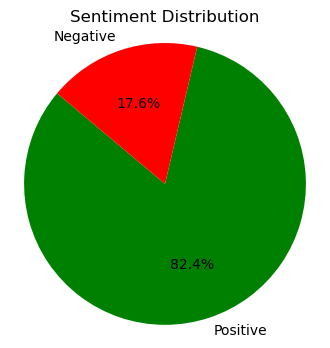

In [12]:
# Data to plot
labels = ['Positive', 'Negative']
sizes = [label_counts_dict_mapped['Positive'], label_counts_dict_mapped['Negative']]  # Sizes in percentage
colors = ['green', 'red']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution')

plt.show()

In [13]:
# Function to count unique words
def count_unique_words(text: str) -> int:
    # Tokenize the text into words
    words = text.split()
    
    # Count the occurrences of unique words
    word_counts = Counter(words)
    
    return len(word_counts)

def count_words(text: str) -> int:
    # Tokenize the text into words
    words = text.split()

    return len(words)

def get_text_metadata(data: pd.DataFrame) -> list[float]:
    review_lengths = data["Review"].apply(count_words) 
    unique_words_count= sum(data["Review"].apply(count_unique_words))
    return [unique_words_count, 
            np.mean(review_lengths), 
            np.median(review_lengths), 
            np.std(review_lengths), 
            np.max(review_lengths),
            np.min(review_lengths)]

In [14]:
before_metaData = get_text_metadata(raw_data)

meta_data_index = ["Unique word count", 
                   "review_length_mean",
                   "review_length_median",
                   "review_length_std",
                   "review_length_max",
                   "review_length_min",]

In [15]:
meta_data = pd.DataFrame(data={'Before_preprocess': before_metaData}, index=meta_data_index)
pd.set_option('display.float_format', '{:.3f}'.format)

In [17]:
chars = set()

#Get all unique characters which appear in the dataset
for item in raw_data["Review"]:
    chars = chars.union(item)
    
chars = sorted(chars)

print(chars)

[' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '\\', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\x81', '\x82', '\x85', '\x8a', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x93', '\x94', '\x95', '\x96', '\x99', '\x9d', '\xa0', '¢', '£', '©', '«', '±', '´', 'µ', '¾', 'À', 'Â', 'Ä', 'Ç', 'È', 'Ù', 'Û', 'Ü', 'à', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ö']


In [18]:
#Save all weird chars apprearing in the dataset
weird_chars = chars[-48:]

In [20]:
def contains_weird_char(word: str):
    for weird_char in weird_chars:
        if(weird_char in word):
            return True
        
    return False

In [21]:
def create_word_cloud(review_data: pd.DataFrame):
    # Concatenate the text data into a single string
    text = ' '.join(review_data['Review'])

    # Generate the word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()

In [23]:
df_positive_reviews = raw_data[raw_data["Sentiment"] == 1]
df_negative_reviews = raw_data[raw_data["Sentiment"] == 0]

##### Colclusions from data exploration(Before pre-process):
* The data appears to be a bit pre-processed before. All words are lower case, there are almost no stop words, 
some words appear to be stemmed already.
* The data is greatly unbalanced, with the vast majority of the sentiment being positive.
* In a simple split fashion, there are almost 1.8M unique words, which can influence noise, reduction is required.
* The review lengths vary greatly.
* There are strange characters in the dataset, which create non-english words in the dataset, and they
contribute to generating noise. Will need to remove them to clean data and reduce noise.


### 2 class claffification

#### Proprocessing data

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [25]:
def preprocess_text_data(data: pd.DataFrame):
  return data.apply(preprocess_text)

def preprocess_text(text: str):
  tokenized_sentence = word_tokenize(text)

  filtered_sentence = [w for w in tokenized_sentence if not w in stop_words]
  filtered_sentence = [lemmatizer.lemmatize(word=w) for w in filtered_sentence]
  filtered_sentence = [word for word in filtered_sentence if word not in string.punctuation]
  filtered_sentence = [word for word in filtered_sentence if not re.match(r'^-?\d+(?:\.\d+)?$', word)]
  filtered_sentence = [word for word in filtered_sentence if not contains_weird_char(word)]
  filtered_sentence = " ".join(filtered_sentence)
  return filtered_sentence.strip()

In [26]:
processed_data = preprocess_text_data(raw_data["Review"])

In [29]:
processed_data = pd.DataFrame(zip(processed_data, raw_data["Sentiment"]), columns = ["Review", "Sentiment"])

In [30]:
meta_data["After_preprocess"] = get_text_metadata(processed_data)

In [31]:
meta_data

,Before_preprocess,After_preprocess
Unique word count,1568106.000,1416794.000
review_length_mean,103.143,97.495
review_length_median,76.000,72.000
review_length_std,99.541,92.999
review_length_max,1755.000,1654.000
review_length_min,7.000,6.000


In [32]:
processed_data_tokenized = processed_data.copy()

In [33]:
tokenizer_iterator = processed_data_tokenized.itertuples()

In [34]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _,text, _ in data_iter:
        yield tokenizer(text)

In [35]:
vocab = build_vocab_from_iterator(yield_tokens(tokenizer_iterator), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [36]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [37]:
# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(processed_data_tokenized, test_size=0.3, stratify=processed_data["Sentiment"],random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Sentiment"],random_state=42)

In [38]:
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [39]:
label_counts_dict_mapped_train = count_labels(train_df["Sentiment"], normalize=False)
label_counts_dict_mapped_val = count_labels(val_df["Sentiment"], normalize=False)
label_counts_dict_mapped_test = count_labels(test_df["Sentiment"], normalize=False)

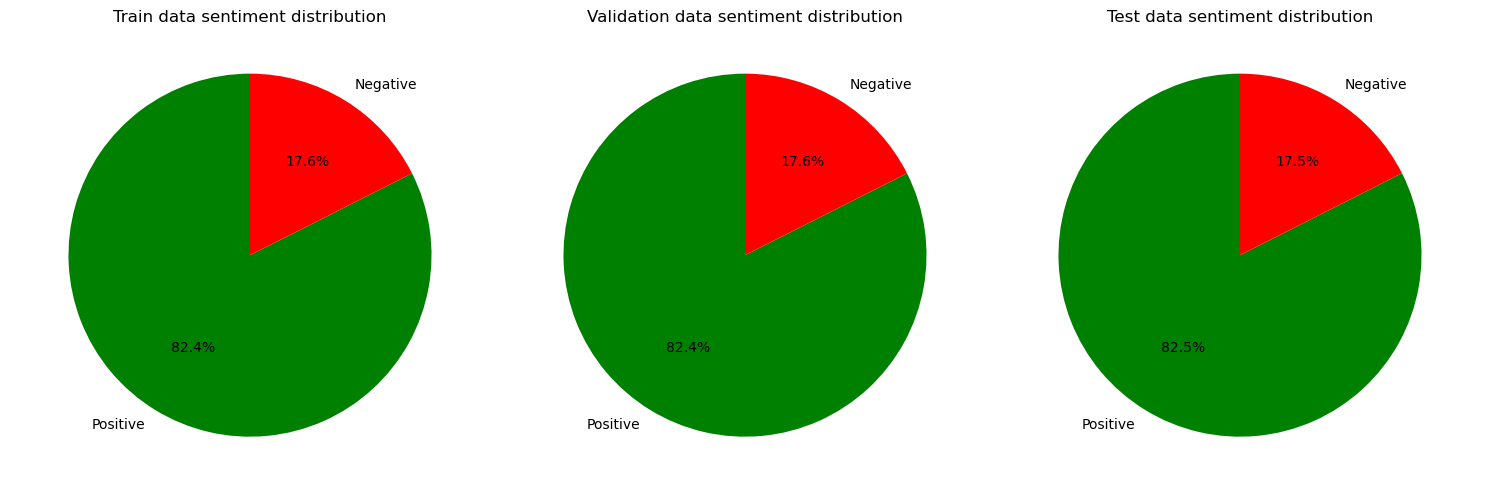

In [40]:
# Data to plot
labels = ['Positive', 'Negative']
sizes_train = [label_counts_dict_mapped_train['Positive'], label_counts_dict_mapped_train['Negative']]
sizes_val = [label_counts_dict_mapped_val['Positive'], label_counts_dict_mapped_val['Negative']]
sizes_test = [label_counts_dict_mapped_test['Positive'], label_counts_dict_mapped_test['Negative']]
colors = ['green', 'red']

# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first pie chart
axs[0].pie(sizes_train, labels=labels, colors = colors,autopct='%1.1f%%', startangle=90)
axs[0].set_title('Train data sentiment distribution')

# Plot second pie chart
axs[1].pie(sizes_val, labels=labels, colors = colors, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Validation data sentiment distribution')

# Plot third pie chart
axs[2].pie(sizes_test, labels=labels, colors = colors, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Test data sentiment distribution')

# Equal aspect ratio ensures that pie is drawn as a circle
axs[0].axis('equal')
axs[1].axis('equal')
axs[2].axis('equal')

plt.tight_layout()
plt.show()

In [41]:
# Define custom dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [42]:
train_dataset = TextDataset(train_df["Review"], train_df["Sentiment"])
val_dataset = TextDataset(val_df["Review"], val_df["Sentiment"])
test_dataset = TextDataset(test_df["Review"], test_df["Sentiment"])

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)

    # Accumulate the dimensions of offsets
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    #Concatenate tensors
    text_list = torch.cat(text_list)
    
    return text_list.to(device), label_list.to(device), offsets.to(device)

In [45]:
BATCH_SIZE = 128
NUM_EPOCHS = 50

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

#### Old implementaion

In [295]:
# n_features = 200
# vectorizer = Word2Vec(processed_data, vector_size=n_features, window=1000, min_count=1, workers=4)

In [296]:
# def embedding_similarity(first_embedding: np.array, second_embedding: np.array):
#     cosine_similarity = np.dot(first_embedding, second_embedding) / (np.linalg.norm((first_embedding) * np.linalg.norm(second_embedding)))
#     return cosine_similarity

In [299]:
# def words2MeanVector(words: list[str]) -> np.ndarray:
#     word_matrix = [vectorizer.wv[word] for word in words if word in vectorizer.wv]
#     word_matrix = np.array(word_matrix)
#     return np.mean(word_matrix, axis = 0)

In [300]:
# vectorized_data = processed_data.apply(words2MeanVector)

In [302]:
#Data_vectorized = pd.DataFrame(zip(vectorized_data, raw_data["Sentiment"]), columns = ["Review", "Sentiment"])

In [304]:
# Data_vectorized = Data_vectorized.sample(frac=1).reset_index(drop=True)

# # Calculate the number of rows for each set
# total_rows = len(Data_vectorized)
# train_rows = int(0.6 * total_rows)
# val_rows = int(0.2 * total_rows)

# # Split the DataFrame into train, validation, and test sets
# Train = Data_vectorized.iloc[:train_rows].reset_index(drop=True)
# Val = Data_vectorized.iloc[train_rows:train_rows + val_rows].reset_index(drop=True)
# Test = Data_vectorized.iloc[train_rows + val_rows:].reset_index(drop=True)

In [305]:
# #Split data into 80% train and 20% test, stratify to maintain class distribution
# X_train, X_test, y_train, y_test = train_test_split(Data_vectorized["Review"], Data_vectorized["Sentiment"], test_size=0.2, stratify=Data_vectorized["Sentiment"], random_state=42)

# # Split the 20% test data into 50% validation and 50% test, stratify to maintain class distribution
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
# X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
# X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

In [307]:
# Create DataLoader for training and test sets
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### Training models

In [50]:
# Define softmax model
class SoftmaxModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(SoftmaxModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc1(embedded)
    
# Initialize model, loss function, and optimizer
modelSoftMax = SoftmaxModel(vocab_size=len(vocab), embed_dim=100, num_classes=2)
criterionSoftMax = nn.CrossEntropyLoss(weight=torch.Tensor(list(label_weights_dict.values())))
optimizerSoftMax = torch.optim.Adam(modelSoftMax.parameters(),weight_decay=1e-4, lr=0.001)

In [58]:
# Define neural network model
class NNSoftmaxModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(NNSoftmaxModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, 5)
        self.fc2 = nn.Linear(5, num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = nn.functional.relu(self.fc1(embedded))
        embedded = self.fc2(embedded)
        return embedded
    
modelNN = NNSoftmaxModel(vocab_size=len(vocab), embed_dim=100, num_classes=2)
criterionNN = nn.CrossEntropyLoss(weight=torch.Tensor(list(label_weights_dict.values())))
optimizerNN = torch.optim.Adam(modelNN.parameters(), weight_decay=1e-4,lr=0.001)

In [100]:
# Define RNN model
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, 128, num_layers=1, bidirectional=bidirectional)
        self.fc = nn.Linear(128 * 2 if bidirectional else 128, num_classes)
        #self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden.squeeze(0))
    
modelRNN = RNN(vocab_size=len(vocab), embedding_dim=100, num_classes=2)
criterionRNN = nn.CrossEntropyLoss(weight=torch.Tensor(list(label_weights_dict.values())))
optimizerRNN = torch.optim.Adam(modelNN.parameters(), weight_decay=1e-4,lr=0.001)

In [47]:
def trainModel(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, criterion: nn, optimizer: torch.optim, n_epochs = NUM_EPOCHS) -> tuple[list[float], list[float], torch.Tensor, torch.Tensor]:
    #Lists will contain tuples of results. (train score, val score)
    losses = []
    accuracies = []


    train_pred_truth = torch.empty(0)
    val_pred_truth = torch.empty(0)

    # Training loop
    for epoch in range(n_epochs):
        train_running_loss = 0.0
        val_running_loss = 0.0

        train_correct, val_correct = 0,0
        train_total, val_total = 0,0

        train_truths = torch.empty(0)
        train_predictions = torch.empty(0)

        model.train()
        for idx, (inputs, labels, offsets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs, offsets)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            #Save results of batch
            train_truths = torch.cat((train_truths, labels), dim=0)
            train_predictions = torch.cat((train_predictions, predicted), dim=0)
        
        train_acc = train_correct/train_total

        # Evaluation
        model.eval()
        with torch.no_grad():
            for idx, (inputs, labels, offsets) in enumerate(val_loader):
                outputs = model(inputs, offsets)
                loss = criterion(outputs, labels)

                val_running_loss += loss

                _, predicted = torch.max(outputs.data, 1)
                # test_predictions = torch.cat((test_predictions, predicted), dim=0)
                # test_truths = torch.cat((test_truths, labels), dim=0)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total

        train_loss = train_running_loss / len(train_loader)
        val_loss = val_running_loss / len(val_loader)
        # Print statistics
        print(f"Epoch [{epoch+1}/{n_epochs}], Accuracy(T/V): ({100 * train_acc:.5}/{100 * val_acc:.5})%")
        
        losses.append((train_loss, val_loss))
        accuracies.append((train_acc, val_acc))
        

    return losses, accuracies, train_predictions, train_truths
    

In [48]:
def testModel(test_loader: DataLoader, model: nn.Module) -> tuple[float, torch.Tensor, torch.Tensor]:
    test_predictions = torch.empty(0)
    test_truths = torch.empty(0)
    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_predictions = torch.cat((test_predictions, predicted), dim=0)
            test_truths = torch.cat((test_truths, labels), dim=0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, test_predictions, test_truths

In [ ]:
lossesSoft, accuraciesSoft, predictions, truths = trainModel(train_dataloader,val_dataloader, modelSoftMax, criterionSoftMax, optimizerSoftMax)

In [ ]:
lossesNN, accuraciesNN, predictionsNN, truthsNN = trainModel(train_dataloader, val_dataloader, modelNN, criterionNN, optimizerNN)

In [101]:
lossesRNN, accuraciesRNN, predictionsRNN, truthsRNN = trainModel(train_dataloader, val_dataloader, modelRNN, criterionRNN, optimizerRNN)

RuntimeError: Expected `len(lengths)` to be equal to batch_size, but got 128 (batch_size=100)

In [53]:
def plot_train_results(losses: list[tuple], accuracies: list):
    train_losses, val_losses = zip(*losses)
    train_accuracies, val_accuracies = zip(*accuracies)

    #Create figure and axis objects for losses and accuracies
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss values for the first model
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_losses, color=color, label='Train loss')
    ax1.plot(val_losses, color='orange', label='Validation loss')  # Assuming you have losses for the second model
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Loss")
    ax1.legend()

    # Plot accuracy values for the first model
    color = 'tab:blue'
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)', color=color)  
    ax2.plot(train_accuracies, color=color, label='Train accuracy')
    ax2.plot(val_accuracies, color='purple', label='Validation accuracy')  # Assuming you have accuracies for the second model
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_title("Accuracy")
    ax2.legend()

    # Title and show the plots
    fig.suptitle('Loss and Accuracy Over Epochs', fontsize=16)
    fig.tight_layout(pad=3.0)
    plt.grid(True)
    plt.show()


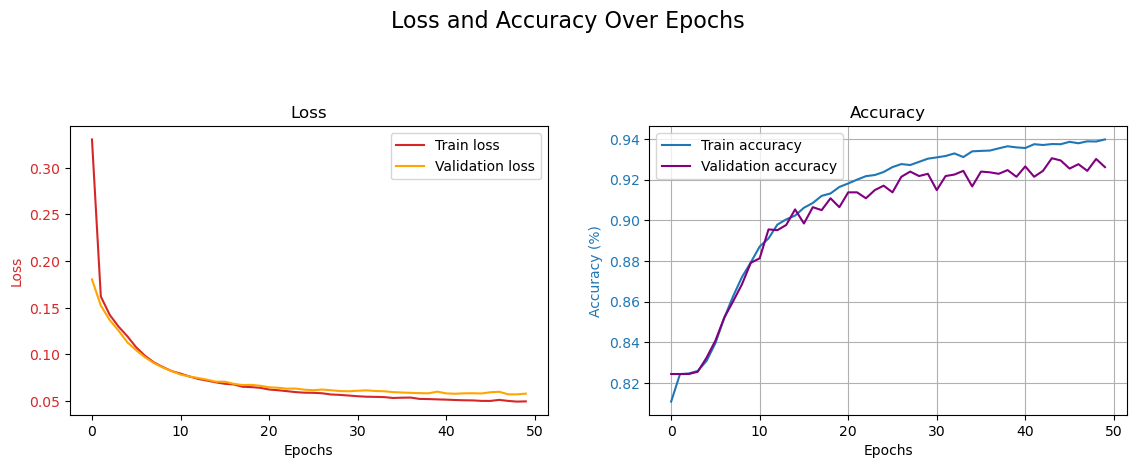

In [54]:
plot_train_results(lossesSoft, accuraciesSoft)

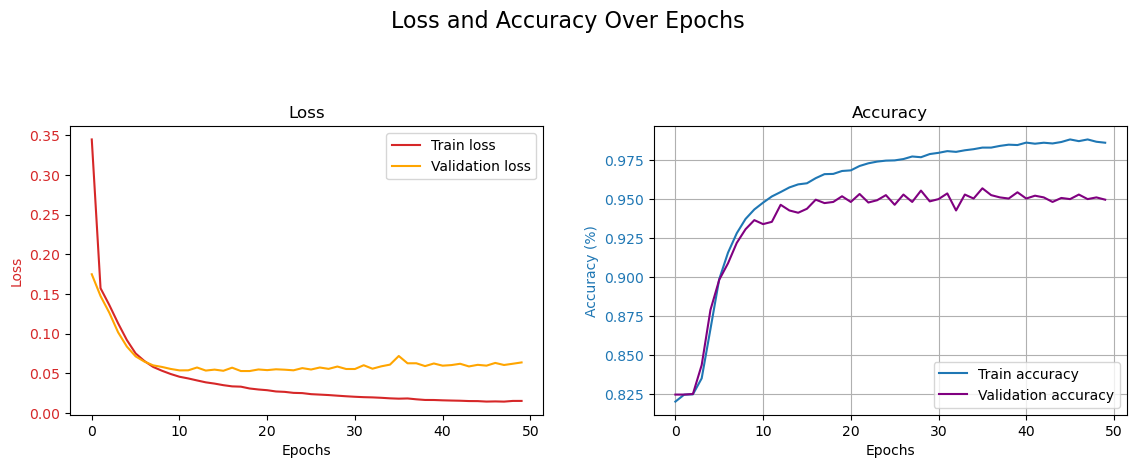

In [60]:
plot_train_results(lossesNN, accuraciesNN)

In [ ]:
# train_truth_list_softmax = torch.Tensor.tolist(truths)
# train_prediction_list_softmax = torch.Tensor.tolist(predictions)
# test_truth_list_softmax = torch.Tensor.tolist(softMaxTruthsTest)
# test_prediction_list_softmax = torch.Tensor.tolist(softMaxPredsTest)

# #-------------------------------------------------------------------------#

# train_truth_list_nn = torch.Tensor.tolist(truthsNN)
# train_prediction_list_nn = torch.Tensor.tolist(predictionsNN)
# test_truth_list_nn = torch.Tensor.tolist(nnTruthsTest)
# test_prediction_list_nn = torch.Tensor.tolist(nnPredsTest)

In [ ]:
# Compute confusion matrices for train and test data
# train_cm_softmax = confusion_matrix(train_truth_list_softmax, train_prediction_list_softmax)
# test_cm_softmax = confusion_matrix(test_truth_list_softmax, test_prediction_list_softmax)

# train_cm_nn = confusion_matrix(train_truth_list_nn, train_prediction_list_nn)
# test_cm_nn = confusion_matrix(test_truth_list_nn, test_prediction_list_nn)

# # Create subplots for train and test confusion matrices
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharey=True)

# # Plot confusion matrix for train data
# sns.heatmap(train_cm_softmax, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=np.unique(train_prediction_list_softmax), 
#             yticklabels=np.unique(train_truth_list_softmax), 
#             ax=axes[0][0])
# axes[0][0].set_title('Train Data Confusion Matrix(Softmax)')
# axes[0][0].set_xlabel('Predicted labels')
# axes[0][0].set_ylabel('True labels')

# # Plot confusion matrix for test data
# sns.heatmap(test_cm_softmax, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=np.unique(test_prediction_list_softmax), 
#             yticklabels=np.unique(test_truth_list_softmax), 
#             ax=axes[0][1])
# axes[0][1].set_title('Test Data Confusion Matrix(Softmax)')
# axes[0][1].set_xlabel('Predicted labels')

# # Plot confusion matrix for train data
# sns.heatmap(train_cm_nn, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=np.unique(train_prediction_list_nn), 
#             yticklabels=np.unique(train_truth_list_nn), 
#             ax=axes[1][0])
# axes[1][0].set_title('Train Data Confusion Matrix(NN)')
# axes[1][0].set_xlabel('Predicted labels')
# axes[1][0].set_ylabel('True labels')

# # Plot confusion matrix for test data
# sns.heatmap(test_cm_nn, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=np.unique(test_prediction_list_nn), 
#             yticklabels=np.unique(test_truth_list_nn), 
#             ax=axes[1][1])
# axes[1][1].set_title('Test Data Confusion Matrix(NN)')
# axes[1][1].set_xlabel('Predicted labels')

# plt.tight_layout()
# plt.show()